## Imports

In [26]:
import time
import math
import random
import copy
from collections import defaultdict
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import display


In [2]:
random.seed(42)
np.random.seed(42)

## Load Data

In [ ]:
courses_raw = pd.read_csv('Data/data_final.csv')
rooms_df = pd.read_csv('Data/Ruang Kuliah.csv')
labs_df = pd.read_csv('Data/Laboratorium.csv')

print('Loaded:', len(courses_raw), 'course rows,', len(rooms_df), 'class rooms,', len(labs_df), 'labs')

courses_raw.columns = [c.strip() for c in courses_raw.columns]
rooms_df.columns = [c.strip() for c in rooms_df.columns]
labs_df.columns = [c.strip() for c in labs_df.columns]

col_map = {}
for col in courses_raw.columns:
    lc = col.lower()
    if 'kode' in lc and 'mk' in lc:
        col_map['kode'] = col
    if ('nama' in lc and 'mk' in lc) or ('nama' in lc and 'mata' in lc):
        col_map['nama'] = col
    if 'sks' in lc:
        col_map['sks'] = col
    if 'praktik' in lc or 'praktikum' in lc:
        col_map['praktikum'] = col
    if 'dosen' in lc:
        col_map['dosen'] = col
    if 'prioritas' in lc:
        col_map['prioritas'] = col

required = ['kode','nama','sks','praktikum','dosen','prioritas']
for r in required:
    if r not in col_map:
        raise ValueError(f"Kolom '{r}' tidak ditemukan di data_final.csv. Kolom tersedia: {courses_raw.columns.tolist()}")

rmap = {}
for col in rooms_df.columns:
    lc = col.lower()
    if 'kode' in lc and 'ruang' in lc:
        rmap['kode'] = col
    if 'lantai' in lc:
        rmap['lantai'] = col
    if 'keterangan' in lc or 'lokasi' in lc or 'nama' in lc:
        if 'keterangan' not in rmap:
            rmap['keterangan'] = col

if 'kode' not in rmap:
    rmap['kode'] = rooms_df.columns[0]

lmap = {}
for col in labs_df.columns:
    lc = col.lower()
    if 'labor' in lc or 'nama' in lc or 'lab' in lc:
        lmap['nama'] = col
    if 'no' in lc or 'kode' in lc or 'id' in lc:
        lmap['kode'] = col

if 'kode' not in lmap:
    lmap['kode'] = labs_df.columns[0]

class_rooms = rooms_df[rmap['kode']].astype(str).tolist()
room_floor = {}
if 'lantai' in rmap:
    for _,r in rooms_df.iterrows():
        room_floor[str(r[rmap['kode']])] = int(r[rmap['lantai']]) if not pd.isna(r[rmap['lantai']]) else 0
else:
    for rm in class_rooms:
        room_floor[str(rm)] = 0

lab_rooms = labs_df[lmap['kode']].astype(str).tolist()
lab_floor = {str(l): -1 for l in lab_rooms} 
all_rooms = class_rooms + lab_rooms

Loaded: 846 course rows, 42 class rooms, 109 labs


## Build courses dictionary 

In [4]:
courses = {}
for idx,row in courses_raw.iterrows():
    kode = str(row[col_map['kode']]).strip()
    key = f"{kode}__{idx}"
    courses[key] = {
        'kode': kode,
        'nama': row[col_map['nama']],
        'sks': int(row[col_map['sks']]),
        'praktikum': int(row[col_map['praktikum']]),
        'dosen': row[col_map['dosen']],
        'prioritas': int(row[col_map['prioritas']]) if not pd.isna(row[col_map['prioritas']]) else 999
    }

course_keys = list(courses.keys())
print('Normalized courses entries:', len(course_keys))

Normalized courses entries: 846


## Timeslot generation

In [ ]:
DAYS = ['Mon','Tue','Wed','Thu','Fri']
HOURS = list(range(7,18))  
available_slots = []
for day in DAYS:
    for h in HOURS:
        if day in ['Mon','Tue','Wed','Thu'] and h==12:
            continue
        if day == 'Fri' and h in (11,12):
            continue
        available_slots.append((day,h))

SLOT_INDEX = {s:i for i,s in enumerate(available_slots)}
print('Total available slots per week per room:', len(available_slots))

session_index_map = []
for k in course_keys:
    for si in range(courses[k]['sks']):
        session_index_map.append((k,si))
TOTAL_SESSIONS = len(session_index_map)
print('Total sessions to schedule:', TOTAL_SESSIONS)

Total available slots per week per room: 49
Total sessions to schedule: 2472


## Building empty schedule structure per course

In [6]:
def make_empty_schedule():
    sched = {}
    for k in course_keys:
        sks = courses[k]['sks']
        pr = courses[k]['praktikum']
        sessions = []
        if pr == 1 and sks >= 1:
            lect_count = max(0, sks-1)
            for i in range(lect_count):
                sessions.append({'type':'lecture','slot':None,'room':None,'lecturer':courses[k]['dosen']})
            sessions.append({'type':'practicum','slot':None,'room':None,'lecturer':'Asprak'})
        else:
            for i in range(sks):
                sessions.append({'type':'lecture','slot':None,'room':None,'lecturer':courses[k]['dosen']})
        sched[k] = sessions
    return sched

## room candidates per course

In [ ]:
room_candidates_per_course = {}
for k in course_keys:
    room_candidates_per_course[k] = {
        'lecture': list(class_rooms),
        'practicum': list(lab_rooms)
    }

def encode_schedule_to_vector(schedule):
    vec = np.zeros(TOTAL_SESSIONS*2, dtype=float)
    for pos,(k,si) in enumerate(session_index_map):
        sess = schedule[k][si]
        sidx = sess['slot'] if sess['slot'] is not None else 0
        vec[2*pos] = sidx
        rlist = room_candidates_per_course[k][sess['type']]
        room = sess['room'] if sess['room'] is not None else (rlist[0] if rlist else '')
        ridx = rlist.index(room) if room in rlist else 0
        vec[2*pos+1] = ridx
    return vec

In [ ]:
def population_diversity_from_schedules(schedules):
    if len(schedules) < 2:
        return 0.0
    vecs = np.array([encode_schedule_to_vector(s) for s in schedules])
    dists = np.linalg.norm(vecs[:,None,:] - vecs[None,:,:], axis=2)
    return np.mean(dists[np.triu_indices_from(dists, k=1)])

## Fitness evaluation with heavy & light penalties

In [ ]:
W_HEAVY = 100000  
W_MOVE = 10       
W_PRIORITY = 5    

def evaluate_schedule_detailed(schedule, w_heavy=W_HEAVY, w_move=W_MOVE, w_priority=W_PRIORITY):
    heavy_count = 0
    light_count = 0
    heavy_detail = defaultdict(int)
    light_detail = defaultdict(int)

    room_use = defaultdict(list)  
    lecturer_use = defaultdict(list)  

    for k,sessions in schedule.items():
        for si,sess in enumerate(sessions):
            if sess['slot'] is None or sess['room'] is None:
                heavy_count += 1
                heavy_detail['Unassigned'] += 1
                continue
            sidx = sess['slot']
            if sidx < 0 or sidx >= len(available_slots):
                heavy_count += 1
                heavy_detail['Time_OutOfRange'] += 1
            room_use[(sidx, sess['room'])].append((k,si))
            lec = sess['lecturer']
            if lec != 'Asprak' and lec is not None:
                lecturer_use[(sidx, lec)].append((k,si))
            if sess['type']=='lecture' and sess['room'] not in class_rooms:
                heavy_count += 1
                heavy_detail['Lecture_In_NonClass'] += 1
            if sess['type']=='practicum' and sess['room'] not in lab_rooms:
                heavy_count += 1
                heavy_detail['Pract_In_NonLab'] += 1

    for kslot,v in room_use.items():
        if len(v) > 1:
            cnt = len(v)-1
            heavy_count += cnt
            heavy_detail['Room_Conflict'] += cnt
    for kslot,v in lecturer_use.items():
        if len(v) > 1:
            cnt = len(v)-1
            heavy_count += cnt
            heavy_detail['Lecturer_Conflict'] += cnt

    soft_score = 0.0
    for k,sessions in schedule.items():
        pr = courses[k]['prioritas']
        for sess in sessions:
            if sess['type']=='lecture':
                soft_score += w_priority * pr
                light_count += 1
                light_detail['Priority_Violation'] += 1

    lec_assigns = defaultdict(list)
    for k,sessions in schedule.items():
        for sess in sessions:
            if sess['lecturer']=='Asprak':
                continue
            if sess['slot'] is None:
                continue
            lec_assigns[sess['lecturer']].append((sess['slot'], sess['room']))
    for lec, assigns in lec_assigns.items():
        assigns_sorted = sorted(assigns, key=lambda x: x[0])
        for i in range(len(assigns_sorted)-1):
            s1,r1 = assigns_sorted[i]
            s2,r2 = assigns_sorted[i+1]
            if s2 == s1 + 1:
                in_class1 = r1 in class_rooms
                in_class2 = r2 in class_rooms
                if in_class1 != in_class2:
                    soft_score += w_move * 5
                    light_count += 1
                    light_detail['Building_Move'] += 1
                else:
                    f1 = room_floor.get(r1,0)
                    f2 = room_floor.get(r2,0)
                    soft_score += w_move * abs(f1-f2)
                    light_count += 1
                    light_detail['Floor_Change'] += 1

    total_cost = w_heavy * heavy_count + soft_score
    is_feasible = (heavy_count == 0)

    result = {
        'total_cost': total_cost,
        'heavy_count': int(heavy_count),
        'light_count': int(light_count),
        'heavy_detail': dict(heavy_detail),
        'light_detail': dict(light_detail),
        'soft_score': float(soft_score),
        'is_feasible': bool(is_feasible)
    }
    return result

In [10]:
def fitness_cost(schedule):
    return evaluate_schedule_detailed(schedule)

## Utilities: random init, repair, small local moves

In [ ]:
def random_schedule():
    sched = make_empty_schedule()
    for k,sessions in sched.items():
        for si,sess in enumerate(sessions):
            sidx = random.randint(0, len(available_slots)-1)
            rlist = room_candidates_per_course[k][sess['type']]
            room = random.choice(rlist) if rlist else None
            sess['slot'] = sidx
            sess['room'] = room
    return sched

In [ ]:
def repair_schedule(schedule, attempts=200):
    sched = copy.deepcopy(schedule)
    room_occ = defaultdict(list)
    for k,sessions in sched.items():
        for si,sess in enumerate(sessions):
            if sess['slot'] is None or sess['room'] is None:
                continue
            room_occ[(sess['slot'], sess['room'])].append((k,si))
    for (slot,room), items in list(room_occ.items()):
        if len(items) <= 1:
            continue
        items_sorted = sorted(items, key=lambda x: courses[x[0]]['prioritas'])
        keeper = items_sorted[0]
        movers = items_sorted[1:]
        for k,si in movers:
            moved = False
            for _ in range(attempts):
                new_slot = random.randint(0, len(available_slots)-1)
                if (new_slot, room) not in room_occ or len(room_occ[(new_slot,room)])==0:
                    sched[k][si]['slot'] = new_slot
                    room_occ[(new_slot,room)].append((k,si))
                    moved = True
                    break
            if not moved:
                rlist = room_candidates_per_course[k][sched[k][si]['type']]
                for r in rlist:
                    if (slot,r) not in room_occ or len(room_occ[(slot,r)])==0:
                        sched[k][si]['room'] = r
                        room_occ[(slot,r)].append((k,si))
                        moved = True
                        break
    return sched

In [ ]:
def random_neighbor(schedule):
    neigh = copy.deepcopy(schedule)
    k = random.choice(course_keys)
    si = random.randrange(len(neigh[k]))
    if random.random() < 0.6:
        neigh[k][si]['slot'] = random.randint(0, len(available_slots)-1)
    else:
        rlist = room_candidates_per_course[k][neigh[k][si]['type']]
        neigh[k][si]['room'] = random.choice(rlist) if rlist else None
    return neigh

## COA implementation

In [ ]:
def coati_optimization(
    iterations=300,
    pop_size=50,
    exploration_ratio=0.8,
    exploitation_ratio=0.2,
    patience=20,
):


    n_explore = int(pop_size * exploration_ratio)
    n_exploit = int(pop_size * exploitation_ratio)

    population = [repair_schedule(random_schedule()) for _ in range(pop_size)]
    evaluations = [evaluate_schedule_detailed(ind) for ind in population]

    best_schedule = copy.deepcopy(population[np.argmin([e['total_cost'] for e in evaluations])])
    best_eval = min(evaluations, key=lambda e: e['total_cost'])
    best_cost = best_eval['total_cost']

    history = {'best_cost': [], 'feasible_best': [], 'diversity': []}
    no_improve = 0
    start_time = time.time()

    for it in trange(iterations, desc="COA"):
        for i in range(n_explore):
            indiv = copy.deepcopy(population[i])
            if random.random() < 0.7:
                for _ in range(random.randint(1,3)):
                    indiv = random_neighbor(indiv)
            else:
                indiv = random_neighbor(indiv)

            indiv = repair_schedule(indiv)
            new_eval = evaluate_schedule_detailed(indiv)
            if new_eval['total_cost'] < evaluations[i]['total_cost']:
                population[i] = indiv
                evaluations[i] = new_eval


        for i in range(n_exploit):
            indiv = copy.deepcopy(population[i])
            if random.random() < 0.5:
                indiv = random_neighbor(indiv)
            else:
                child = copy.deepcopy(best_schedule)
                mkey = random.choice(course_keys)
                if len(child[mkey]) > 0:
                    si = random.randrange(len(child[mkey]))
                    indiv[mkey][si] = copy.deepcopy(child[mkey][si])
            indiv = repair_schedule(indiv)
            new_eval = evaluate_schedule_detailed(indiv)
            if new_eval['total_cost'] < evaluations[i]['total_cost']:
                population[i] = indiv
                evaluations[i] = new_eval


        best_idx = np.argmin([e['total_cost'] for e in evaluations])
        curr_best = evaluations[best_idx]
        curr_best_cost = curr_best['total_cost']
        if curr_best_cost < best_cost:
            best_schedule = copy.deepcopy(population[best_idx])
            best_eval = curr_best
            best_cost = curr_best_cost
            no_improve = 0
        else:
            no_improve += 1

        diversity = population_diversity_from_schedules(population)
        feasible_best = min(
            [e['total_cost'] for e in evaluations if e['is_feasible']] or [np.nan]
        )
        history['best_cost'].append(best_cost)
        history['feasible_best'].append(feasible_best)
        history['diversity'].append(diversity)

        if no_improve >= patience:
            print(f"⏹️ COA early stop at iteration {it} (no improvement)")
            break

    total_time = time.time() - start_time
    return best_schedule, best_eval, {'history': history, 'runtime_s': total_time}

## GA implementation (baseline)

In [ ]:
def ga_optimize(generations=200, pop_size=60, cx_prob=0.8, mut_prob=0.15, patience=None, tol=1e-6):
    pop = [repair_schedule(random_schedule()) for _ in range(pop_size)]
    evals = [fitness_cost(ind) for ind in pop]

    best_feasible = None; best_feasible_cost = float('inf')
    best_overall = None; best_overall_cost = float('inf')
    history = {'best_feasible':[], 'best_overall':[], 'avg_cost':[], 'feasible_count':[], 'diversity':[]}
    start_time = time.time()

    no_improve = 0
    last_best = float('inf')

    for g in range(generations):
        new_pop = []
        while len(new_pop) < pop_size:
            a,b = random.sample(range(pop_size), 2)
            p1 = pop[a] if evals[a]['total_cost'] < evals[b]['total_cost'] else pop[b]
            a,b = random.sample(range(pop_size), 2)
            p2 = pop[a] if evals[a]['total_cost'] < evals[b]['total_cost'] else pop[b]
            if random.random() < cx_prob:
                keys = list(course_keys)
                cp = random.randint(1, len(keys)-1)
                child = {}
                for i,k in enumerate(keys):
                    child[k] = copy.deepcopy(p1[k]) if i < cp else copy.deepcopy(p2[k])
            else:
                child = copy.deepcopy(p1)
            if random.random() < mut_prob:
                m = random.choice(course_keys)
                si = random.randrange(len(child[m]))
                if random.random() < 0.6:
                    child[m][si]['slot'] = random.randint(0,len(available_slots)-1)
                else:
                    rlist = room_candidates_per_course[m][child[m][si]['type']]
                    child[m][si]['room'] = random.choice(rlist) if rlist else None
            child = repair_schedule(child)
            new_pop.append(child)
        pop = new_pop
        evals = [fitness_cost(ind) for ind in pop]

        for p,e in zip(pop,evals):
            if e['total_cost'] < best_overall_cost:
                best_overall = copy.deepcopy(p); best_overall_cost = e['total_cost']
        feasible = [(p,e) for p,e in zip(pop,evals) if e['is_feasible']]
        if feasible:
            p,e = min(feasible, key=lambda pe: pe[1]['total_cost'])
            if e['total_cost'] < best_feasible_cost:
                best_feasible = copy.deepcopy(p); best_feasible_cost = e['total_cost']

        history['best_feasible'].append(best_feasible_cost if best_feasible is not None else np.nan)
        history['best_overall'].append(best_overall_cost)
        history['avg_cost'].append(np.mean([e['total_cost'] for e in evals]))
        vecs = np.array([encode_schedule_to_vector(p) for p in pop])
        mean_vec = vecs.mean(axis=0)
        history['diversity'].append(np.mean([np.linalg.norm(v-mean_vec) for v in vecs]))
        history['feasible_count'].append(sum(1 for e in evals if e['is_feasible']))

        if np.isfinite(last_best):
            improvement = (last_best - best_overall_cost)
            if improvement <= tol:
                no_improve += 1
            else:
                no_improve = 0
            last_best = best_overall_cost
        else:
            last_best = best_overall_cost
        if (patience is not None) and (no_improve >= patience):
            print(f"GA early stop at gen {g} (no_improve >= {patience})")
            break

    total_time = time.time() - start_time
    final = best_feasible if best_feasible is not None else best_overall
    final_eval = evaluate_schedule_detailed(final)
    return final, final_eval, {'history':history, 'runtime_s':total_time}

## PSO (discrete) implementation

In [16]:
def decode_particle(vec, room_lists):
    sched = make_empty_schedule()
    arr = [int(round(x)) for x in vec]
    for i,(k,si) in enumerate(session_index_map):
        sidx = max(0, min(len(available_slots)-1, arr[2*i]))
        rlist = room_lists[i]
        ridx = arr[2*i+1] % len(rlist) if len(rlist)>0 else 0
        room = rlist[ridx] if len(rlist)>0 else None
        sched[k][si]['slot'] = sidx
        sched[k][si]['room'] = room
    return sched

In [ ]:
def ps0_optimize(particles=30, iterations=200, w=0.7, c1=1.4, c2=1.4, patience=None, tol=1e-6):
    room_lists = []
    for (k,si) in session_index_map:
        t = make_empty_schedule()[k][si]['type']
        room_lists.append(room_candidates_per_course[k][t])

    pos = [ np.array([ random.randint(0,len(available_slots)-1) if i%2==0 else random.randint(0, max(1,len(room_lists[i//2])-1)) for i in range(2*TOTAL_SESSIONS)], dtype=float) for _ in range(particles) ]
    vel = [ np.zeros_like(pos[0]) for _ in range(particles) ]
    pbest = [p.copy() for p in pos]
    pbest_score = [float('inf')]*particles
    gbest = None; gbest_score=float('inf')

    start_time = time.time()
    for p in range(particles):
        sched = decode_particle(pos[p], room_lists)
        sched = repair_schedule(sched)
        ev = evaluate_schedule_detailed(sched)
        pbest[p] = pos[p].copy(); pbest_score[p]=ev['total_cost']
        if ev['total_cost'] < gbest_score:
            gbest = pos[p].copy(); gbest_score=ev['total_cost']

    history = {'best_overall':[], 'best_feasible':[], 'diversity':[]}
    no_improve = 0
    last_best = gbest_score

    for it in trange(iterations, desc='PSO'):
        for i in range(particles):
            r1=random.random(); r2=random.random()
            vel[i] = w*vel[i] + c1*r1*(pbest[i]-pos[i]) + c2*r2*(gbest-pos[i])
            pos[i] = pos[i] + vel[i]
            sched = decode_particle(pos[i], room_lists)
            sched = repair_schedule(sched)
            ev = evaluate_schedule_detailed(sched)
            if ev['total_cost'] < pbest_score[i]:
                pbest[i] = pos[i].copy(); pbest_score[i] = ev['total_cost']
                if ev['total_cost'] < gbest_score:
                    gbest = pos[i].copy(); gbest_score = ev['total_cost']
        pop_scheds = [repair_schedule(decode_particle(p, room_lists)) for p in pos]
        D = population_diversity_from_schedules(pop_scheds)
        history['diversity'].append(D)
        history['best_overall'].append(gbest_score)
        history['best_feasible'].append(np.nan) 
        if np.isfinite(last_best):
            improvement = (last_best - gbest_score)
            if improvement <= tol:
                no_improve += 1
            else:
                no_improve = 0
            last_best = gbest_score
        if (patience is not None) and (no_improve >= patience):
            print(f"PSO early stop at iter {it} (no_improve >= {patience})")
            break

    total_time = time.time() - start_time
    final_sched = repair_schedule(decode_particle(gbest, room_lists))
    final_eval = evaluate_schedule_detailed(final_sched)
    return final_sched, final_eval, {'history':history, 'runtime_s':total_time}


## ACO (basic) implementation

In [ ]:
def aco_optimize(ants=30, iterations=200, alpha=1, beta=2, rho=0.1, patience=None, tol=1e-6):
    n_slots = len(available_slots)
    pheromone = np.ones((TOTAL_SESSIONS, n_slots)) * 0.1
    start_time = time.time()
    best_sched = None
    best_eval = None
    best_cost = float('inf')
    history = {'best_overall':[], 'diversity':[]}

    no_improve = 0
    last_best = float('inf')

    for it in trange(iterations, desc='ACO'):
        all_scheds = []
        all_evals = []

        for a in range(ants):
            sched = make_empty_schedule()
            for idx, (k, si) in enumerate(session_index_map):
                ps = pheromone[idx] ** alpha
                if ps.sum() == 0:
                    probs = np.ones(len(ps)) / len(ps)
                else:
                    probs = ps / ps.sum()
                sidx = np.random.choice(range(n_slots), p=probs)
                sess_type = sched[k][si]['type']
                rlist = room_candidates_per_course[k][sess_type]
                room = random.choice(rlist) if rlist else None
                sched[k][si]['slot'] = sidx
                sched[k][si]['room'] = room
            sched = repair_schedule(sched)
            ev = evaluate_schedule_detailed(sched)
            all_scheds.append(sched)
            all_evals.append(ev)

            if ev['total_cost'] < best_cost:
                best_cost = ev['total_cost']
                best_sched = copy.deepcopy(sched)
                best_eval = ev

        pheromone = (1 - rho) * pheromone
        for s, e in zip(all_scheds, all_evals):
            contrib = 1.0 / (1.0 + e['total_cost'])
            for idx, (k, si) in enumerate(session_index_map):
                slot = s[k][si]['slot']
                pheromone[idx, slot] += contrib

        D = population_diversity_from_schedules(all_scheds)
        history['diversity'].append(D)
        history['best_overall'].append(best_cost)

        if np.isfinite(last_best):
            improvement = (last_best - best_cost)
            if improvement <= tol:
                no_improve += 1
            else:
                no_improve = 0
            last_best = best_cost
        else:
            last_best = best_cost
        if (patience is not None) and (no_improve >= patience):
            print(f"ACO early stop at iter {it} (no_improve >= {patience})")
            break

    total_time = time.time() - start_time
    final = best_sched
    final_eval = evaluate_schedule_detailed(final)
    return final, final_eval, {'history':history, 'runtime_s':total_time}

## SA (Simulated Annealing) implementation

In [ ]:
def sa_optimize(iterations=3000, T0=100.0, cooling=0.95, patience=None, tol=1e-6):
    current = repair_schedule(random_schedule())
    current_eval = evaluate_schedule_detailed(current)
    best = copy.deepcopy(current)
    best_eval = current_eval
    history = {'best_cost':[], 'temperature':[]}
    start_time = time.time()
    T = T0

    no_improve = 0
    last_best = best_eval['total_cost']

    for it in trange(iterations, desc='SA'):
        neighbor = random_neighbor(current)
        neighbor = repair_schedule(neighbor)
        ev_new = evaluate_schedule_detailed(neighbor)
        delta = ev_new['total_cost'] - current_eval['total_cost']
        if delta < 0 or random.random() < math.exp(-delta / (T + 1e-9)):
            current = neighbor
            current_eval = ev_new
            if ev_new['total_cost'] < best_eval['total_cost']:
                best = copy.deepcopy(neighbor)
                best_eval = ev_new
        T *= cooling
        history['best_cost'].append(best_eval['total_cost'])
        history['temperature'].append(T)

        if np.isfinite(last_best):
            improvement = (last_best - best_eval['total_cost'])
            if improvement <= tol:
                no_improve += 1
            else:
                no_improve = 0
            last_best = best_eval['total_cost']
        if (patience is not None) and (no_improve >= patience):
            print(f"SA early stop at iter {it} (no_improve >= {patience})")
            break

    total_time = time.time() - start_time
    return best, best_eval, {'history':history, 'runtime_s':total_time}

## Run ALL

In [ ]:
def run_and_compare_algorithms(num_runs=3,
                               num_iterations=100,
                               population_size=50,
                               patience=20):
    algorithms = {
        'COA': lambda: coati_optimization(pop_size=population_size, iterations=num_iterations, patience=patience),
        'GA': lambda: ga_optimize(generations=num_iterations, pop_size=population_size, cx_prob=0.8, mut_prob=0.1, patience=patience),
        'PSO': lambda: ps0_optimize(particles=population_size//2 if population_size//2>0 else 10, iterations=num_iterations, w=0.7, c1=1.4, c2=1.4, patience=patience),
        'ACO': lambda: aco_optimize(ants=population_size//2 if population_size//2>0 else 10, iterations=num_iterations, alpha=1, beta=2, rho=0.5, patience=patience),
        'SA': lambda: sa_optimize(iterations=max(200,num_iterations*5), T0=100.0, cooling=0.95, patience=patience)
    }

    summary_records = []
    detailed_results = {}

    for name, fn in algorithms.items():
        print(f"\n=== Running algorithm: {name} (runs={num_runs}) ===")
        run_costs = []
        run_feasible_counts = []
        run_heavy = []
        run_light = []
        run_runtimes = []
        run_histories = []
        for r in range(num_runs):
            print(f" Run {r+1}/{num_runs} ...", end='')
            start = time.time()
            sched, ev, meta = fn()
            dur = meta.get('runtime_s', time.time()-start)
            run_costs.append(ev['total_cost'])
            run_feasible_counts.append(1 if ev['is_feasible'] else 0)
            run_heavy.append(ev['heavy_count'])
            run_light.append(ev['light_count'])
            run_runtimes.append(dur)
            run_histories.append(meta.get('history'))
            print(f" done (cost={ev['total_cost']}, feasible={ev['is_feasible']}, time={dur:.2f}s)")
            detailed_results.setdefault(name, []).append({'schedule':sched, 'eval':ev, 'meta':meta})

        summary_records.append({
            'algo': name,
            'runs': num_runs,
            'best_cost_mean': float(np.mean(run_costs)),
            'best_cost_std': float(np.std(run_costs)),
            'feasible_rate': float(np.mean(run_feasible_counts)),
            'heavy_mean': float(np.mean(run_heavy)),
            'light_mean': float(np.mean(run_light)),
            'runtime_mean_s': float(np.mean(run_runtimes))
        })
        detailed_results[name].append({'representative_history': run_histories[0]})

    summary_df = pd.DataFrame(summary_records).sort_values(['feasible_rate','best_cost_mean'], ascending=[False, True])
    return summary_df, detailed_results

## Run experiments

In [ ]:
NUM_RUNS = 3         
NUM_ITERATIONS = 100  
POP_SIZE = 50         
PATIENCE = 20         

summary_df, detailed_results = run_and_compare_algorithms(num_runs=NUM_RUNS,
                                                          num_iterations=NUM_ITERATIONS,
                                                          population_size=POP_SIZE,
                                                          patience=PATIENCE)

print("\n===== SUMMARY =====")
print(summary_df.to_string(index=False))


=== Running algorithm: COA (runs=3) ===
 Run 1/3 ...

COA: 100%|██████████| 100/100 [09:26<00:00,  5.67s/it]


 done (cost=97426695.0, feasible=False, time=567.01s)
 Run 2/3 ...

COA: 100%|██████████| 100/100 [08:51<00:00,  5.32s/it]


 done (cost=97526225.0, feasible=False, time=531.59s)
 Run 3/3 ...

COA: 100%|██████████| 100/100 [08:49<00:00,  5.30s/it]


 done (cost=97926125.0, feasible=False, time=529.83s)

=== Running algorithm: GA (runs=3) ===
 Run 1/3 ... done (cost=92127105.0, feasible=False, time=443.31s)
 Run 2/3 ... done (cost=92826635.0, feasible=False, time=420.19s)
 Run 3/3 ... done (cost=91627075.0, feasible=False, time=420.11s)

=== Running algorithm: PSO (runs=3) ===
 Run 1/3 ...

PSO:  58%|█████▊    | 58/100 [05:48<04:12,  6.01s/it]

PSO early stop at iter 58 (no_improve >= 20)
 done (cost=101825605.0, feasible=False, time=351.41s)
 Run 2/3 ...


PSO:  42%|████▏     | 42/100 [04:33<06:17,  6.51s/it]

PSO early stop at iter 42 (no_improve >= 20)
 done (cost=100425855.0, feasible=False, time=276.11s)
 Run 3/3 ...


PSO:  97%|█████████▋| 97/100 [10:09<00:18,  6.29s/it]


PSO early stop at iter 97 (no_improve >= 20)
 done (cost=99924585.0, feasible=False, time=612.40s)

=== Running algorithm: ACO (runs=3) ===
 Run 1/3 ...

ACO:  24%|██▍       | 24/100 [02:04<06:35,  5.20s/it]


ACO early stop at iter 24 (no_improve >= 20)
 done (cost=99124665.0, feasible=False, time=124.81s)
 Run 2/3 ...

ACO:  31%|███       | 31/100 [02:38<05:52,  5.11s/it]


ACO early stop at iter 31 (no_improve >= 20)
 done (cost=97526725.0, feasible=False, time=158.53s)
 Run 3/3 ...

ACO:  22%|██▏       | 22/100 [01:51<06:34,  5.06s/it]


ACO early stop at iter 22 (no_improve >= 20)
 done (cost=97426155.0, feasible=False, time=111.41s)

=== Running algorithm: SA (runs=3) ===
 Run 1/3 ...

SA:   6%|▌         | 29/500 [00:03<00:50,  9.29it/s]


SA early stop at iter 29 (no_improve >= 20)
 done (cost=101426665.0, feasible=False, time=3.12s)
 Run 2/3 ...

SA: 100%|██████████| 500/500 [00:45<00:00, 10.89it/s]


 done (cost=99725125.0, feasible=False, time=45.90s)
 Run 3/3 ...

SA:  98%|█████████▊| 490/500 [00:44<00:00, 11.06it/s]

SA early stop at iter 490 (no_improve >= 20)
 done (cost=97724785.0, feasible=False, time=44.29s)

===== SUMMARY =====
algo  runs  best_cost_mean  best_cost_std  feasible_rate  heavy_mean  light_mean  runtime_mean_s
  GA     3    9.219360e+07   4.919707e+05            0.0  921.666667 3112.333333      427.869843
 COA     3    9.762635e+07   2.158334e+05            0.0  976.000000 3051.333333      542.807918
 ACO     3    9.802585e+07   7.780647e+05            0.0  980.000000 3056.666667      131.584816
  SA     3    9.962552e+07   1.512926e+06            0.0  996.000000 3029.333333       31.104591
 PSO     3    1.007253e+08   8.044632e+05            0.0 1007.000000 3023.000000      413.304940


## Comparative evaluation & visualizations

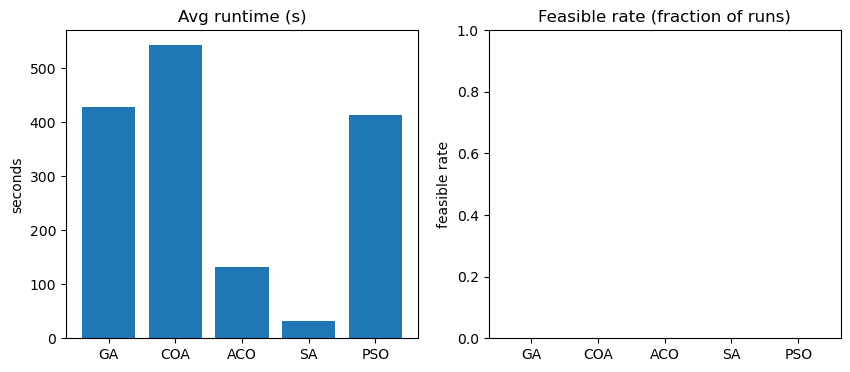

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(summary_df['algo'], summary_df['runtime_mean_s'])
plt.title('Avg runtime (s)')
plt.ylabel('seconds')

plt.subplot(1,2,2)
plt.bar(summary_df['algo'], summary_df['feasible_rate'])
plt.title('Feasible rate (fraction of runs)')
plt.ylabel('feasible rate')
plt.ylim(0,1)
plt.show()

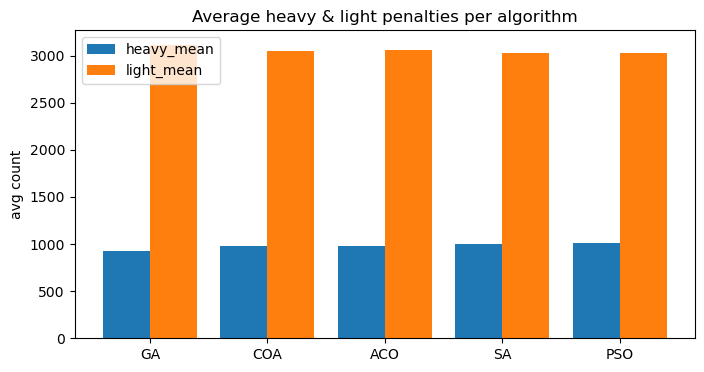

In [ ]:
plt.figure(figsize=(8,4))
x = np.arange(len(summary_df))
plt.bar(x-0.2, summary_df['heavy_mean'], width=0.4, label='heavy_mean')
plt.bar(x+0.2, summary_df['light_mean'], width=0.4, label='light_mean')
plt.xticks(x, summary_df['algo'])
plt.ylabel('avg count')
plt.title('Average heavy & light penalties per algorithm')
plt.legend()
plt.show()

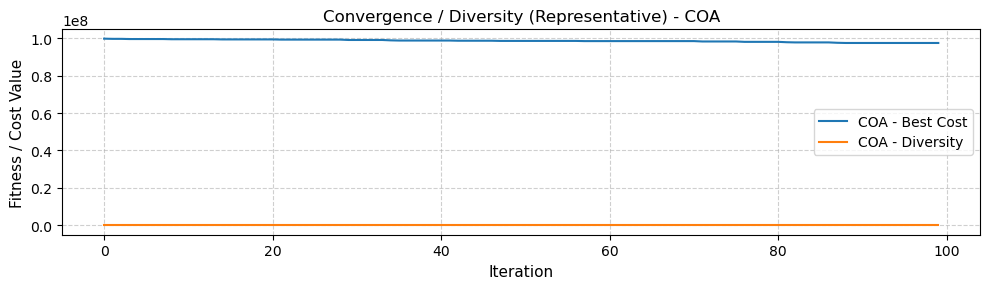

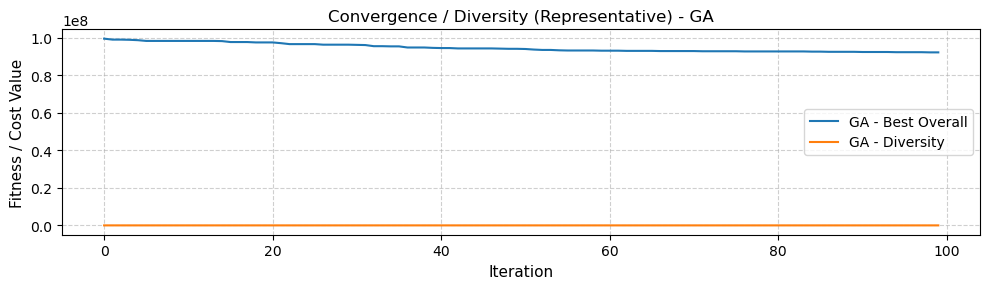

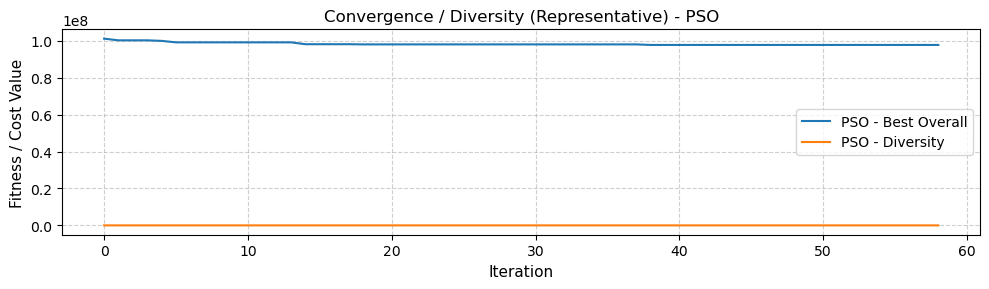

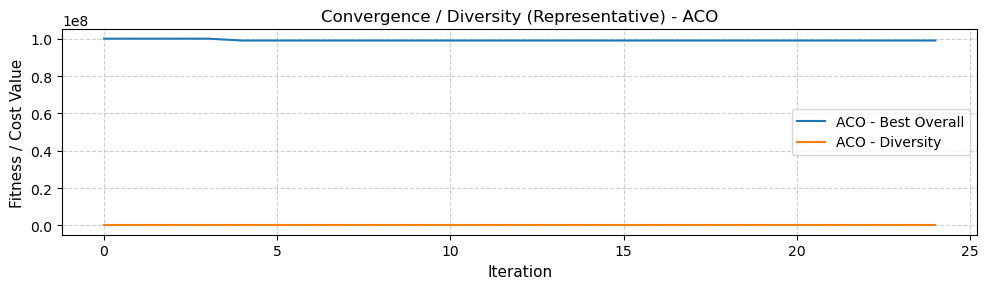

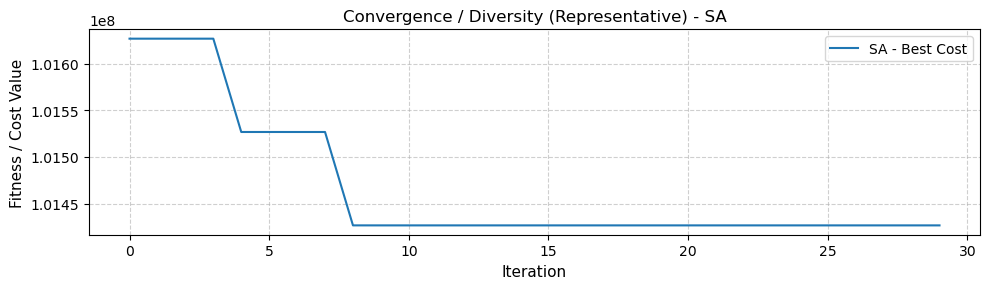

In [ ]:
for name, runs in detailed_results.items():
    rep = None
    for item in reversed(runs):
        if 'representative_history' in item:
            rep = item['representative_history']
            break
    if rep is None:
        continue

    hist = rep
    plt.figure(figsize=(10, 3))

    if isinstance(hist, dict):
        if 'best_overall' in hist:
            plt.plot(hist['best_overall'], label=f'{name} - Best Overall')
        elif 'best_cost' in hist:
            plt.plot(hist['best_cost'], label=f'{name} - Best Cost')
        if 'diversity' in hist:
            plt.plot(hist['diversity'], label=f'{name} - Diversity')

    plt.title(f'Convergence / Diversity (Representative) - {name}')
    plt.xlabel('Iteration', fontsize=11)
    plt.ylabel('Fitness / Cost Value', fontsize=11)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [35]:
df_summary = summary_df[["algo", 'runs', "best_cost_mean", "runtime_mean_s"]]
df_summary = df_summary.sort_values(by="best_cost_mean", ascending=True)

print("\n=== Ringkasan Hasil Akhir ===")
display(df_summary)


=== Ringkasan Hasil Akhir ===


,algo,runs,best_cost_mean,runtime_mean_s
1,GA,3,9.219360e+07,427.869843
0,COA,3,9.762635e+07,542.807918
3,ACO,3,9.802585e+07,131.584816
4,SA,3,9.962552e+07,31.104591
2,PSO,3,1.007253e+08,413.304940


## Save summary and representative schedule CSVs

In [ ]:
summary_df.to_csv('comparison_summary.csv', index=False)
print('Saved comparison_summary.csv')

for name, runs in detailed_results.items():
    if len(runs) == 0:
        continue
    rep_run = runs[0]  
    sched = rep_run['schedule']
    ev = rep_run['eval']
    rows = []
    for k,sessions in sched.items():
        for sess in sessions:
            slot = sess['slot']
            day,hour = available_slots[slot] if slot is not None and 0<=slot<len(available_slots) else (None,None)
            rows.append({
                'algo': name,
                'kode_MK': courses[k]['kode'],
                'nama': courses[k]['nama'],
                'type': sess['type'],
                'day': day,
                'hour': hour,
                'room': sess['room'],
                'lecturer': sess['lecturer']
            })
    df_out = pd.DataFrame(rows)
    fname = f'representative_schedule_{name}.csv'
    df_out.to_csv(fname, index=False)
    print('Saved', fname, 'eval heavy:', ev['heavy_detail'], 'light:', ev['light_detail'])

Saved comparison_summary.csv
Saved representative_schedule_COA.csv eval heavy: {'Room_Conflict': 191, 'Lecturer_Conflict': 783} light: {'Priority_Violation': 2249, 'Floor_Change': 803}
Saved representative_schedule_GA.csv eval heavy: {'Room_Conflict': 191, 'Lecturer_Conflict': 730} light: {'Priority_Violation': 2249, 'Floor_Change': 869}
Saved representative_schedule_PSO.csv eval heavy: {'Room_Conflict': 191, 'Lecturer_Conflict': 827} light: {'Priority_Violation': 2249, 'Floor_Change': 764}
Saved representative_schedule_ACO.csv eval heavy: {'Room_Conflict': 191, 'Lecturer_Conflict': 800} light: {'Priority_Violation': 2249, 'Floor_Change': 796}
Saved representative_schedule_SA.csv eval heavy: {'Room_Conflict': 191, 'Lecturer_Conflict': 823} light: {'Priority_Violation': 2249, 'Floor_Change': 760}
